In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install torchmetrics

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = datasets.MNIST('data',train = True, transform=ToTensor(), download=True)
test_data = datasets.MNIST('data', train = False, transform=ToTensor(), download = True)

class_names = train_data.classes

100%|██████████| 9912422/9912422 [00:00<00:00, 248153940.82it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38009317.17it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72809586.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22652233.97it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



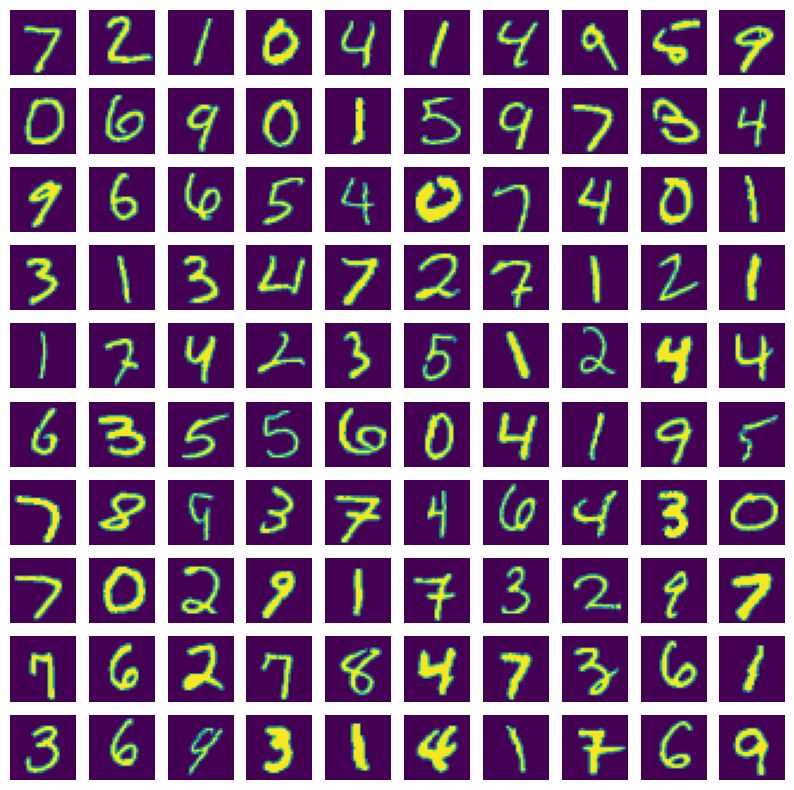

In [ ]:
plt.figure(figsize = (10,10))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(test_data[i][0].squeeze())
  plt.axis(False)

In [ ]:
train_dataloader = DataLoader(train_data,16,True)
test_dataloader = DataLoader(test_data,16,True)

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
class NumberModule(nn.Module):
  def __init__(self, input: int, hidden: int, output: int):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(input,hidden,2,1,1),
        nn.ReLU(),
        nn.Conv2d(hidden,hidden,2,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(hidden,hidden,2,1,1),
        nn.ReLU(),
        nn.Conv2d(hidden,hidden,2,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*64, output)
    )
  def forward(self,x):
    x = self.layer1(x)
    #print(x.shape)
    x = self.layer2(x)
    #print(x.shape)
    return self.layer3(x)

In [ ]:
from pathlib import Path
import requests

if Path('helper_functions.py').is_file():
  print('File Exists')
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn

In [ ]:
model_0 = NumberModule(1,20,len(class_names)).to(device)

tensor_rand = torch.randn(size=(1,28,28)).to(device)
model_0(tensor_rand.unsqueeze(0))

tensor([[ 0.0203,  0.0140, -0.0253, -0.0986,  0.0530, -0.0185,  0.0009, -0.0058,
          0.0504,  0.0500]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr = .1)

In [ ]:
def train_loop(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn = accuracy_fn,
              device: torch.device = device):
  train_loss = 0
  train_acc = 0
  for batch, (x,y) in enumerate(dataset):
    x, y = x.to(device), y.to(device)
    model.train()
    y_preds = model(x)
    loss = loss_fn(y_preds, y)
    train_loss+=loss
    train_acc += accuracy_fn(y, y_preds.argmax(dim = 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataset)
  train_acc /= len(dataset)
  print(f'Train loss: {train_loss: .5f} Train acc: {train_acc: .2f}%.')

In [ ]:
def test_loop(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn = accuracy_fn,
              device: torch.device = device):
  model.eval()
  test_acc = 0
  pred_list = []
  true_list = []
  test_loss = 0
  with torch.inference_mode():
    for x,y in dataset:
      x, y = x.to(device), y.to(device)
      test_pred = model(x)
      test_loss+=loss_fn(test_pred,y)
      test_acc += accuracy_fn(y,test_pred.argmax(dim = 1))
      pred_list.append(torch.argmax(torch.softmax(test_pred, dim = 0),dim = 1))
      true_list.append(y)
    test_loss /= len(dataset)
    test_acc /= len(dataset)
    print(f'Test Loss: {test_loss: .5f} Test acc: {test_acc: .2f}')
    return pred_list, true_list

In [ ]:
from tqdm.auto import tqdm
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_loop(model_0,train_dataloader,loss_fn,optimizer)
  list_pred, list_true = test_loop(model_0,test_dataloader,loss_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss:  0.23212 Train acc:  92.32%.
Test Loss:  0.06564 Test acc:  97.85
Epoch: 1
Train loss:  0.06614 Train acc:  97.93%.
Test Loss:  0.04901 Test acc:  98.25
Epoch: 2
Train loss:  0.05217 Train acc:  98.33%.
Test Loss:  0.04174 Test acc:  98.55


In [ ]:
import random
test_samples = []
torch.manual_seed(42)

test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

In [ ]:
y_preds = []
loss = 0
model_0.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader,desc = 'Making predictions... '):
    X, y = X.to(device), y.to(device)
    y_logits = model_0(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1)
    y_preds.append(y_pred.cpu())
    loss += loss_fn(y_logits, y)
  # print(y_preds)
  y_pred_tensor = torch.cat(y_preds)


Making predictions... :   0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim = 0).to(device)
      pred_logits = model(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(),dim = 0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [ ]:
pred_probs = make_predictions(model_0,test_samples)
pred_classes = pred_probs.argmax(dim=1)

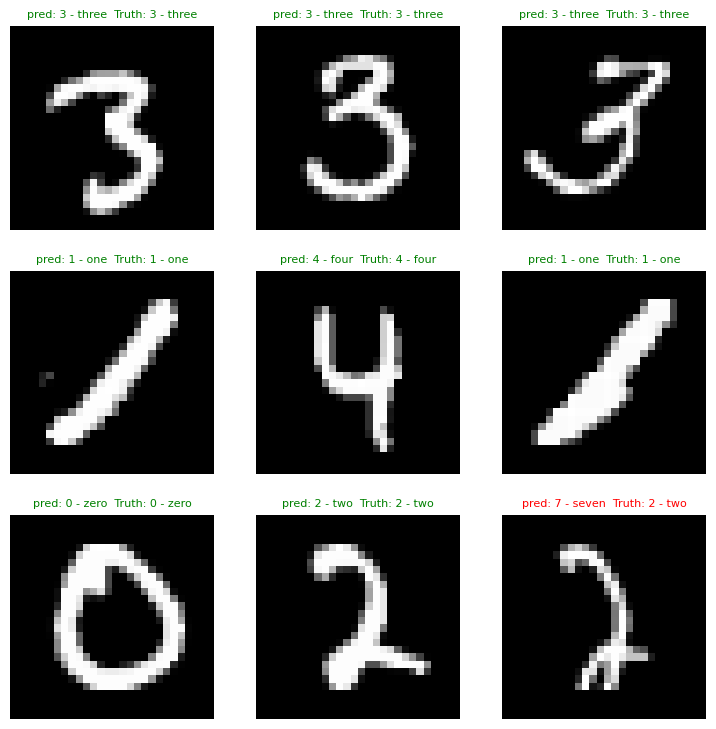

In [ ]:
plt.figure(figsize = (9,9))
nrow = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrow,ncols, i+1)
  plt.imshow(sample.squeeze(), cmap = 'gray')
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"pred: {pred_label}  Truth: {truth_label}"
  color = 'green' if pred_label == truth_label else 'red'
  plt.title(title_text, c = color, fontsize = 8)
  plt.axis(False)

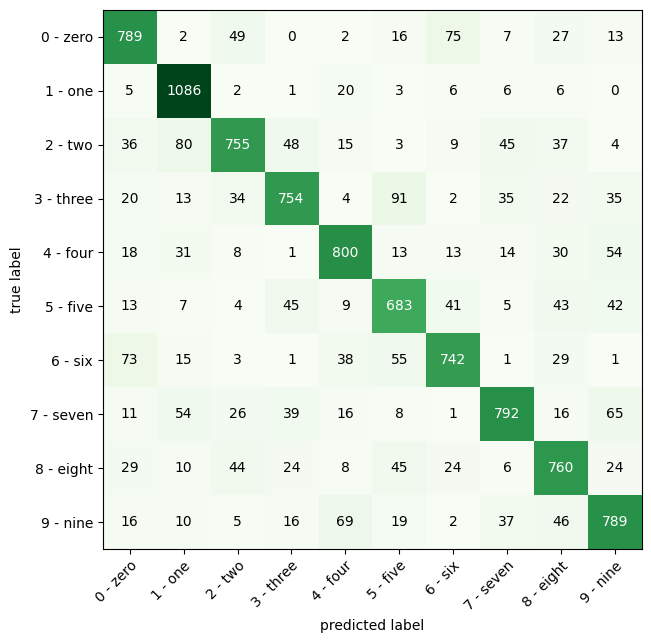

In [ ]:
confmat = ConfusionMatrix(task = 'multiclass', num_classes = len(class_names))
confmat_tensor = confmat(preds=torch.cat(list_pred).to('cpu'),target = torch.cat(list_true).to('cpu'))

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names = class_names, figsize = (10,7), cmap= 'Greens')